In [1]:
# feature importance
from sklearn.ensemble import RandomForestRegressor
from data import *
from model import *

taxi_type = YELLOW
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = RandomForestRegressor(n_estimators=100, 
                              max_depth=10)

# FEATURES = ['pu_location_id', 'do_location_id', 'passenger_count', 'trip_distance', 
#             'trip_duration', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 
#             'improvement_surcharge', 'congestion_surcharge']

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

importance = model.feature_importances_
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": importance}).sort_values(by="Importance", ascending=False)
print(feature_importance)


sql engine ready
                  Feature  Importance
3           trip_distance    0.848797
4           trip_duration    0.139423
7            tolls_amount    0.002858
6                 mta_tax    0.002725
5              tip_amount    0.002519
0          pu_location_id    0.000985
8                   extra    0.000947
10   congestion_surcharge    0.000871
1          do_location_id    0.000683
2         passenger_count    0.000188
9   improvement_surcharge    0.000004


In [2]:
storeModel(model, f'{taxi_type}_{VARIABLE}_{RANDOM_FOREST}')

In [1]:
from sklearn.ensemble import RandomForestRegressor
from data import *
from model import *

taxi_type = YELLOW
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = RandomForestRegressor(n_estimators=100, 
                              max_depth=10)

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_test = []
    y_pred = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y_test.append(df[VARIABLE])

        y_pred.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
merged_y_test = pd.concat(y_test, ignore_index=True)
merged_y_pred = np.concatenate(y_pred)

showPerformance(merged_y_test, merged_y_pred)

sql engine ready
Model Accuracy Metrics:
Mean Absolute Error (MAE): 0.72
Root Mean Squared Error (RMSE): 2.25
R-squared (Accuracy): 0.98


sql engine ready
Mean Squared Error: 5.085122952691208


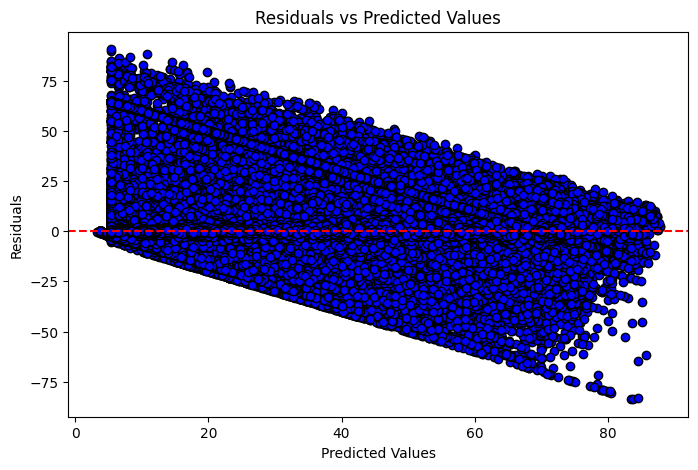

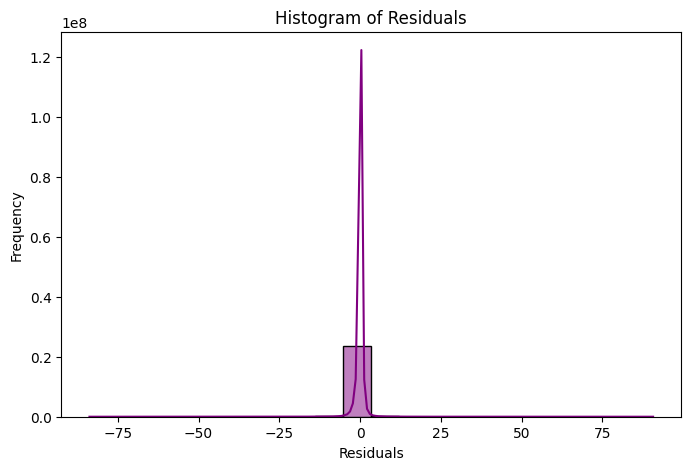

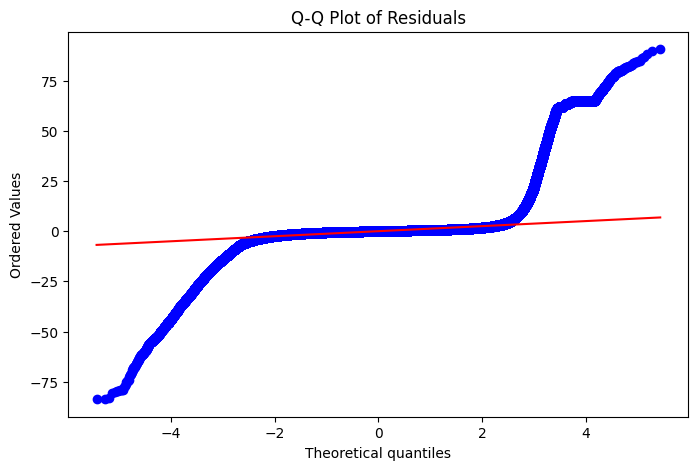

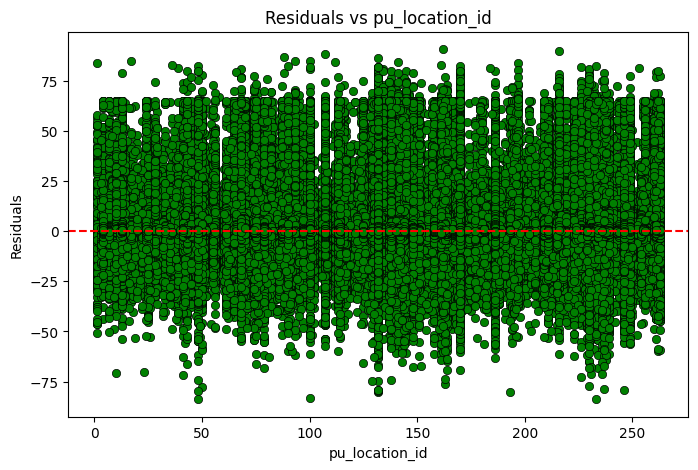

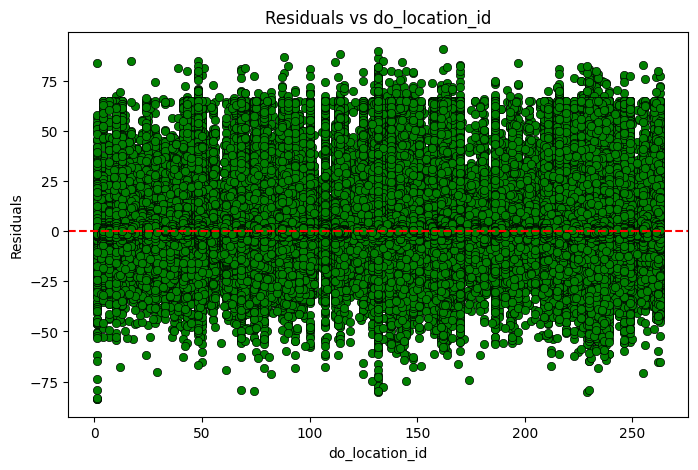

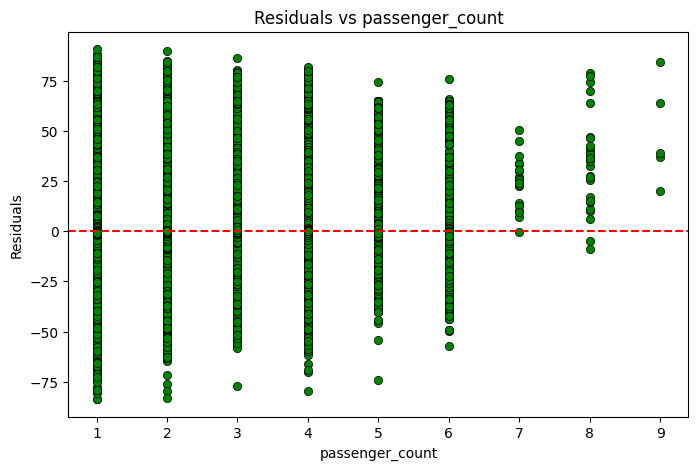

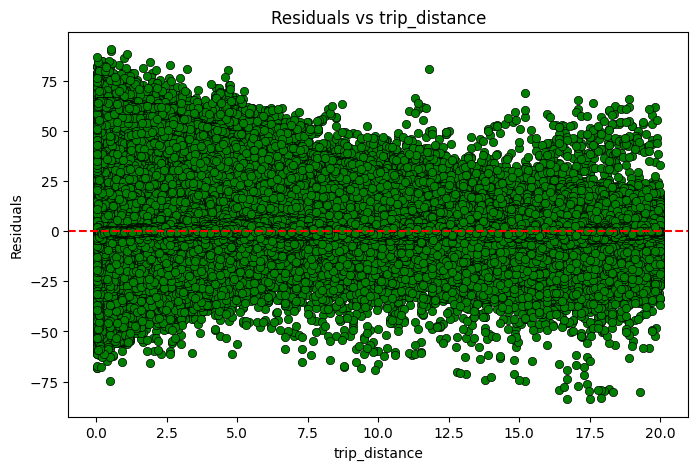

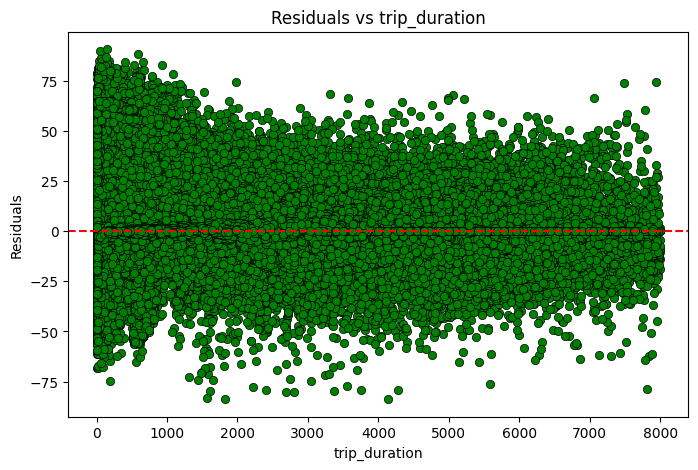

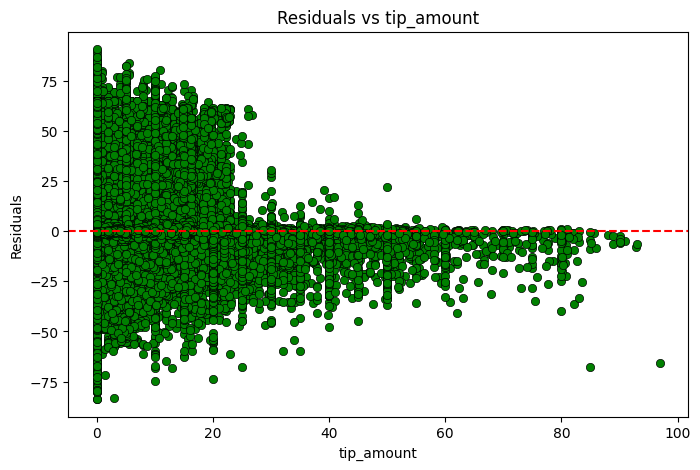

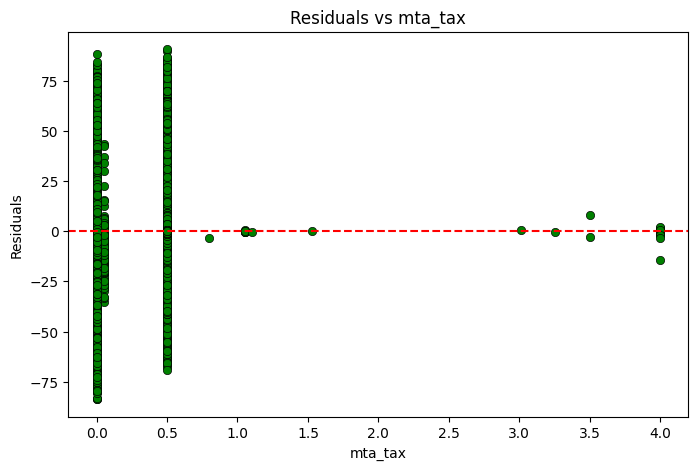

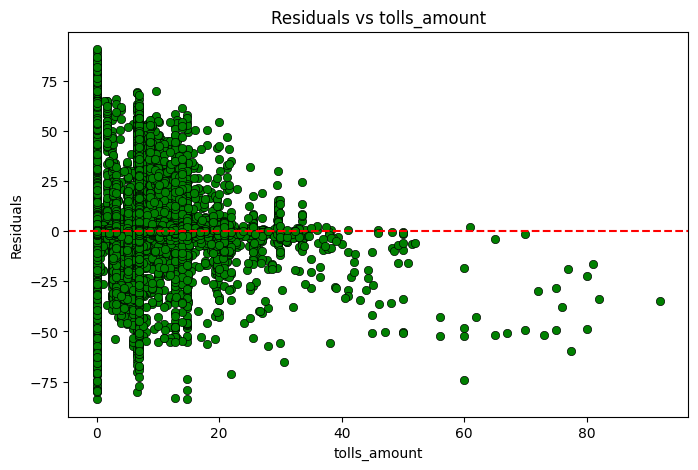

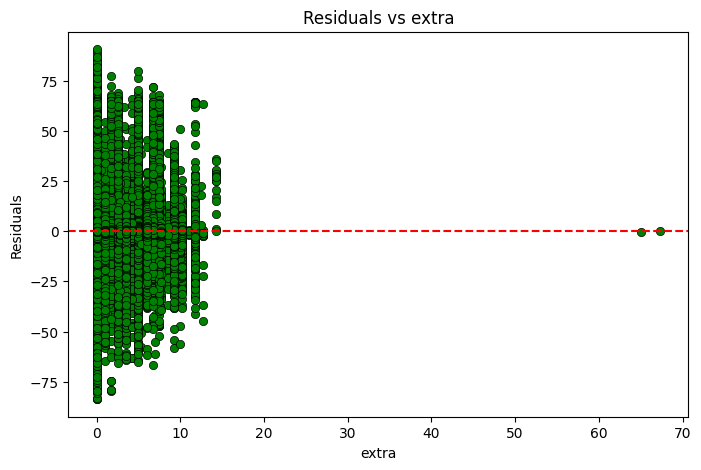

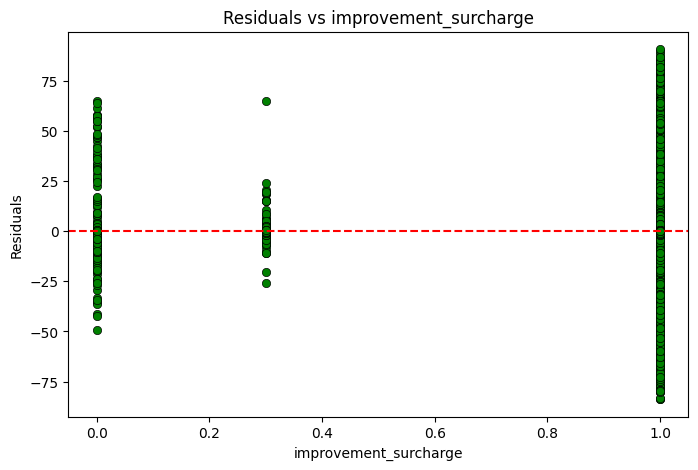

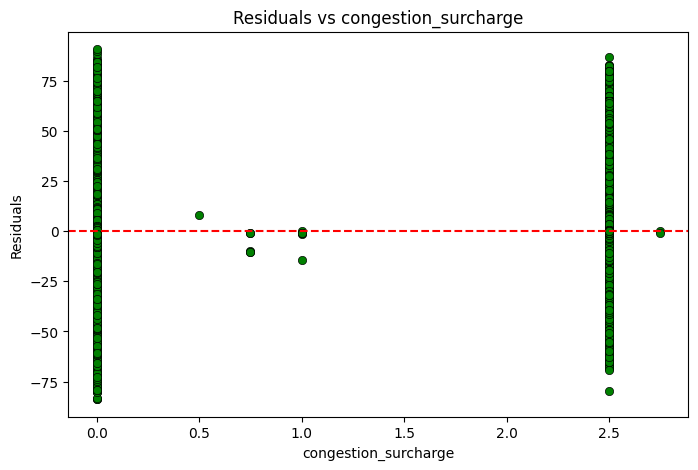

In [1]:
# Residual Analysis
from data import *
from model import *

taxi_type = YELLOW
# train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = loadModel(f'{taxi_type}_{VARIABLE}_{RANDOM_FOREST}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_t_chunk = []
    y_p_chunk = []
    X_t_chunk = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        X_t_chunk.append(X)
        y_t_chunk.append(df[VARIABLE])

        y_p_chunk.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
X_test = pd.concat(X_t_chunk, ignore_index=True)
y_test = pd.concat(y_t_chunk, ignore_index=True)
y_pred = np.concatenate(y_p_chunk)


residualAnalysis(X_test, y_test, y_pred)